<a href="https://colab.research.google.com/github/jina-ai/pqlite/blob/feat-colab-notebook/notebooks/fashion_product_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building a Neural Search System for Ecommerce Product Search

In this tutorial, we will build a neural search engine for images of [Fasion Product Image (Small)](https://www.kaggle.com/paramaggarwal/fashion-product-images-small).

![image](https://storage.googleapis.com/kaggle-datasets-images/175990/396802/720cd7ceb25eb130d0b873464f734370/data-original.png?t=2019-04-26-16-40-29)


<div align="left">
<a href="#" role="button"><img src="https://img.shields.io/static/v1?label=&amp;message=View%20On%20GitHub&amp;color=586069&amp;logo=github&amp;labelColor=2f363d"></a>&nbsp;
<a href="https://colab.research.google.com/github/GokuMohandas/MLOps/blob/main/notebooks/tagifai.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>
</div>

---

## Pre-requisites

Skip this if you've already downloaded them.


In [1]:
!rm -rf data
!pip install gdown
!gdown https://drive.google.com/uc?id=1aMUlWCjIgflBK9dBUU1dB91_zn36_i-p
!unzip fashion.zip -d data > /dev/null

Downloading...
From: https://drive.google.com/uc?id=1aMUlWCjIgflBK9dBUU1dB91_zn36_i-p
To: /content/fashion.zip
100% 593M/593M [00:03<00:00, 149MB/s]


In [ ]:
!pip install pandas
!pip install Pillow
!pip install matplotlib
!pip install torchvision

!pip install jina==2.5.4
!pip install pqlite==0.1.0

In [3]:
!rm -rf workspace
!mkdir workspace

---

# Problem(s) definition

*problem 1:*

We want to search Fashion Product by Image


*problem 2:*

Search Fashion Product with *TEXT* + *VISUAL* (multi-modal search)


In [4]:
import os
import glob

from PIL import Image
from jina import Document, DocumentArray

from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow

os.environ['JINA_LOG_LEVEL'] = 'DEBUG'

## 1. Document - the data

# Document

Here we prepare the data we want to search through.

Jina provides two abstractions for data.

- `Document`
- `DocumentArray`

These can be text, image, audio data or any modality you can imagine.

In [5]:
import pandas as pd

df = pd.read_csv('/content/data/styles.csv', warn_bad_lines=True, error_bad_lines=False)
# df.loc[df['year'].notnull(), 'year'] = df.loc[df['year'].notnull(), 'year'].apply(int)
df = df.dropna()
df['year'] = df['year'].astype(int)
df

b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expected 10 fields, saw 11\nSkipping line 35748: expected 10 fields, saw 11\nSkipping line 35962: expected 10 fields, saw 11\nSkipping line 37770: expected 10 fields, saw 11\nSkipping line 38105: expected 10 fields, saw 11\nSkipping line 38275: ex

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt
...,...,...,...,...,...,...,...,...,...,...
44419,17036,Men,Footwear,Shoes,Casual Shoes,White,Summer,2013,Casual,Gas Men Caddy Casual Shoe
44420,6461,Men,Footwear,Flip Flops,Flip Flops,Red,Summer,2011,Casual,Lotto Men's Soccer Track Flip Flop
44421,18842,Men,Apparel,Topwear,Tshirts,Blue,Fall,2011,Casual,Puma Men Graphic Stellar Blue Tshirt
44422,46694,Women,Personal Care,Fragrance,Perfume and Body Mist,Blue,Spring,2017,Casual,Rasasi Women Blue Lady Perfume


In [6]:
MAX_NUM_DOCS = 200

def get_product_docs(max_num: int = MAX_NUM_DOCS):
    da = DocumentArray.empty(max_num)
    for index, row in df.iterrows():
        if index >= max_num:
            break

        doc_id = row.pop('id')
        doc_uri = f'/content/data/images/{doc_id}.jpg'

        doc = Document(id=doc_id, uri=doc_uri, tags=dict(row))
        doc.load_uri_to_image_blob()
        doc.load_uri_to_image_blob() # image shape (HEIGHT, WIDTH, CHANNELS)
        doc.set_image_blob_channel_axis(-1, 0) # image shape (CHANNELS, HEIGHT, WIDTH)
        da[index] = doc
    
    return da

In [7]:
docs = get_product_docs()
print(len(docs)) # should be 200

200


##  Flows Step by Step (Image -> Product)

The Flow is the main pipeline in Jina. It describes the way data should be loaded, processed, stored etc. within the system. 

It is made up of components (called Executors), which are the ones doing the specific task.

Ex. we have a crafter Executor, which preprocesses the data; an Encoder Executor, which loads the model and *encodes* that data;  Indexer Executor, which stores and retrieves the data etc.

In [23]:
!rm -rf workspace/*

In [32]:
from jina import Flow

f = Flow().add(
    name='encoder', uses='jinahub://CLIPImageEncoder/v0.1', install_requirements=True).add(
    name='indexer', uses='jinahub://PQLiteIndexer/v0.1.0', 
        uses_with={
            'dim': 512,
            'metric': 'cosine',
            'columns': [
                        ('year', 'int'), 
                        ('baseColour', 'str'), 
                        ('masterCategory', 'str')
            ],
            'include_metadata': True,
        }, 
        uses_metas={'workspace': '/content/workspace'}, 
        install_requirements=True
)

f.plot()

           Flow@3103[I]:flow visualization: https://mermaid.ink/svg/ICAgICAgICAgICAgJSV7aW5pdDp7ICAidGhlbWUiOiAiYmFzZSIsICAidGhlbWVWYXJpYWJsZXMiOiB7ICAgICAgInByaW1hcnlDb2xvciI6ICIjZmZmIiwgICAgICAicHJpbWFyeUJvcmRlckNvbG9yIjogIiNmZmYiLCAgICAgICJtYWluQmtnIjogIiMzMkM4Q0QiLCAgICAgICJjbHVzdGVyQmtnIjogIiNFRUVERTc4QyIsICAgICAgInNlY29uZGFyeUJvcmRlckNvbG9yIjogIm5vbmUiLCAgICAgICJ0ZXJ0aWFyeUJvcmRlckNvbG9yIjogIm5vbmUiLCAgICAgICJsaW5lQ29sb3IiOiAiI2E2ZDhkYSIgICAgICB9fX0lJSAgICAgICAgICAgIApmbG93Y2hhcnQgTFI7CnN1YmdyYXBoIGVuY29kZXI7CmVuY29kZXIvcGVhLTBbamluYWh1YjovL0NMSVBJbWFnZUVuY29kZXIvdjAuMV06OjpQRUE7CmVuZDsKc3ViZ3JhcGggaW5kZXhlcjsKaW5kZXhlci9wZWEtMFtqaW5haHViOi8vUFFMaXRlSW5kZXhlci92MC4xLjBdOjo6UEVBOwplbmQ7CmdhdGV3YXlzdGFydFtnYXRld2F5XTo6OkdBVEVXQVkgLS0+IGVuY29kZXI6OjpQT0Q7CmVuY29kZXI6OjpQT0QgLS0+IGluZGV4ZXI6OjpQT0Q7CmluZGV4ZXI6OjpQT0QgLS0+IGdhdGV3YXllbmRbZ2F0ZXdheV06OjpHQVRFV0FZOwpjbGFzc0RlZiBJTlNQRUNUIHN0cm9rZTojRjI5QzlGCmNsYXNzRGVmIEpPSU5fSU5TUEVDVCBzdHJva2U6I0YyOUM5RgpjbGFzc0RlZiBHQVRFV0FZIGZpbGw6

In [22]:
!ls -lsth workspace/PQLiteIndexer/0/cell_0

total 2.0M
2.0M -rw-r--r-- 1 root root 2.0M Dec 14 05:33 data.mdb
4.0K -rw-r--r-- 1 root root 8.0K Dec 14 05:33 lock.mdb


In [17]:
with f:
    f.index(inputs=docs, show_progress=True)

⠋ 0/3 waiting encoder indexer gateway to be ready...        gateway@3869[D]:setting up sockets...
        gateway@3869[D]:control over ipc:///tmp/tmpn9y0zxoc
        gateway@3869[D]:input 0.0.0.0:57415
        gateway@3869[D]:input tcp://0.0.0.0:57415 (ROUTER_BIND) output tcp://0.0.0.0:49731 (ROUTER_BIND) control over ipc:///tmp/tmpn9y0zxoc (PAIR_BIND)
        gateway@3103[D]:ready and listening
⠹ 1/3 waiting encoder indexer to be ready...        indexer@3868[D]:setting up sockets...
        indexer@3868[D]:control over tcp://0.0.0.0:34781
        indexer@3868[D]:input 0.0.0.0:58165
        indexer@3868[D]:input tcp://0.0.0.0:58165 (ROUTER_BIND) output tcp://0.0.0.0:51501 (ROUTER_BIND) control over tcp://0.0.0.0:34781 (PAIR_BIND)
⠸ 1/3 waiting encoder indexer to be ready...        indexer@3868[D]:recv ControlRequest (STATUS)  from ▸indexer/ZEDRuntime▸⚐
        indexer@3868[D]:skip executor: not data request
        indexer@3103[D]:ready and listening
⠏ 2/3 waiting encoder to be ready..

⠋ Working... ━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━ 0:00:16 estimating...         encoder@3867[D]:output 0.0.0.0:58165
        encoder@3867[D]:recv DataRequest (/index) - (698193e91b814a9fa69df886430efa19)  from gateway▸encoder/ZEDRuntime▸⚐


        indexer@3868[D]:recv DataRequest (/index) - (78bdea02107044169ae46a20669c48b7)  from gateway▸encoder/ZEDRuntime▸indexer/ZEDRuntime▸⚐
        indexer@3868[E]:AssertionError()
 add "--quiet-error" to suppress the exception details
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/jina/peapods/runtimes/zmq/zed.py", line 285, in _msg_callback
    processed_msg = self._callback(msg)
  File "/usr/local/lib/python3.7/dist-packages/jina/peapods/runtimes/zmq/zed.py", line 271, in _callback
    msg = self._post_hook(self._handle(self._pre_hook(msg)))
  File "/usr/local/lib/python3.7/dist-packages/jina/peapods/runtimes/zmq/zed.py", line 226, in _handle
    peapod_name=self.name,
  File "/usr/local/lib/python3.7/dist-packages/jina/peapods/runtimes/request_handlers/data_request_handler.py", line 165, in handle
    field='groundtruths',
  File "/usr/local/lib/python3.7/dist-packages/jina/executors/__init__.py", line 194, in __call__
    self, **kwargs
  File "

2021-12-14 05:33:46.305 | DEBUG    | pqlite.container:insert:203 - => 100 new docs added


⠸       DONE ━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━ 0:00:32 100% ETA: 0 seconds 60 steps done in 32 seconds
        gateway@3103[D]:waiting for ready or shutdown signal from runtime
        gateway@3103[D]: Cancel runtime
        gateway@3103[D]: Wait to shutdown
        gateway@3869[D]:#sent: 2 #recv: 2 sent_size: 2.8 MB recv_size: 3.2 MB
        gateway@3869[D]:Received message is empty.
        gateway@3103[D]: Joining the process
        gateway@3869[D]: Process terminated
        gateway@3103[D]: Successfully joined the process
        gateway@3103[D]:terminated
        gateway@3103[D]: Joining the process
        gateway@3103[D]: Successfully joined the process
        indexer@3103[D]:waiting for ready or shutdown signal from runtime
        indexer@3103[D]: Cancel runtime
        indexer@3103[D]:Sending TERMINATE command for the 1th time
        indexer@3868[D]:recv ControlRequest (TERMINATE)  from ▸indexer/ZEDRuntime▸⚐
        indexer@3868[D]:Handled #0 during flush of socke

In [36]:
with f:
  resp = f.search(inputs=docs[1], return_results=True, parameters={'limit': 5, 'filter': {'year': {'$gte': 2017}}})




⠋ 0/3 waiting encoder indexer gateway to be ready...        gateway@4493[D]:setting up sockets...
        gateway@4493[D]:control over ipc:///tmp/tmpop4r6vg5
        gateway@4493[D]:input 0.0.0.0:52947
        gateway@4493[D]:input tcp://0.0.0.0:52947 (ROUTER_BIND) output tcp://0.0.0.0:36981 (ROUTER_BIND) control over ipc:///tmp/tmpop4r6vg5 (PAIR_BIND)
        gateway@3103[D]:ready and listening
⠹ 1/3 waiting encoder indexer to be ready...

2021-12-14 05:41:59.603 | INFO     | pqlite.index:_rebuild_index:307 - Rebuild the index of cell-0 (100 docs)...
2021-12-14 05:41:59.663 | DEBUG    | pqlite.container:insert:203 - => 100 new docs added


⠸ 1/3 waiting encoder indexer to be ready...        indexer@4492[D]:setting up sockets...
        indexer@4492[D]:control over tcp://0.0.0.0:37197
        indexer@4492[D]:input 0.0.0.0:51419
        indexer@4492[D]:input tcp://0.0.0.0:51419 (ROUTER_BIND) output tcp://0.0.0.0:33887 (ROUTER_BIND) control over tcp://0.0.0.0:37197 (PAIR_BIND)
        indexer@4492[D]:recv ControlRequest (STATUS)  from ▸indexer/ZEDRuntime▸⚐
        indexer@4492[D]:skip executor: not data request
        indexer@3103[D]:ready and listening
⠋ 2/3 waiting encoder to be ready...        encoder@4491[D]:setting up sockets...
        encoder@4491[D]:control over tcp://0.0.0.0:58555
        encoder@4491[D]:input 0.0.0.0:45961
        encoder@4491[D]:input tcp://0.0.0.0:45961 (ROUTER_BIND) output tcp://0.0.0.0:42013 (ROUTER_BIND) control over tcp://0.0.0.0:58555 (PAIR_BIND)
⠙ 2/3 waiting encoder to be ready...        encoder@4491[D]:recv ControlRequest (STATUS)  from ▸encoder/ZEDRuntime▸⚐
        encoder@4491[D]:skip

        encoder@4491[D]:output 0.0.0.0:51419
        indexer@4492[D]:recv DataRequest (/search) - (fff9cf1764c443e2a0f7e1de28e89f44)  from gateway▸encoder/ZEDRuntime▸indexer/ZEDRuntime▸⚐
        indexer@4492[D]:output 0.0.0.0:52947
        gateway@3103[D]:waiting for ready or shutdown signal from runtime
        gateway@3103[D]: Cancel runtime
        gateway@3103[D]: Wait to shutdown
        gateway@4493[D]:#sent: 1 #recv: 1 sent_size: 15.1 KB recv_size: 99.5 KB
        gateway@4493[D]:Received message is empty.
        gateway@3103[D]: Joining the process
        gateway@4493[D]: Process terminated
        gateway@3103[D]: Successfully joined the process
        gateway@3103[D]:terminated
        gateway@3103[D]: Joining the process
        gateway@3103[D]: Successfully joined the process
        indexer@3103[D]:waiting for ready or shutdown signal from runtime
        indexer@3103[D]: Cancel runtime
        indexer@3103[D]:Sending TERMINATE command for the 1th time
        indexer@4

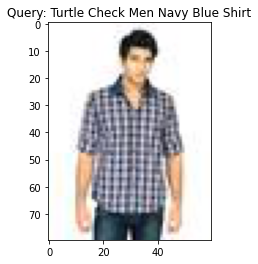

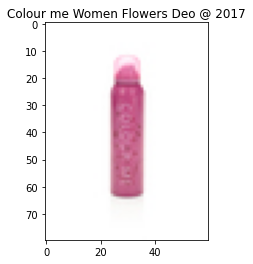

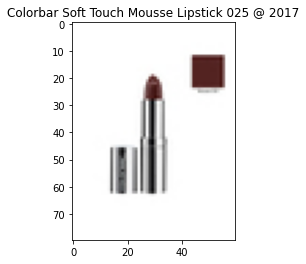

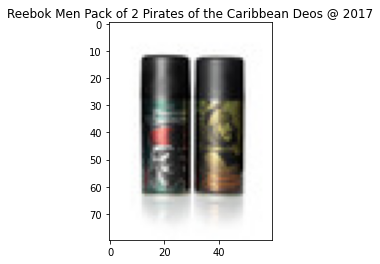

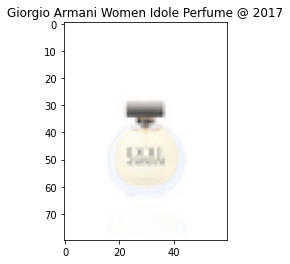

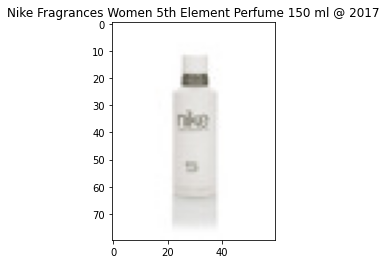

In [37]:
img = Image.open(docs[0].uri)
imshow(img)
plt.title(f'Query: {docs[0].tags["productDisplayName"]}')
plt.show()
for doc in resp[0].docs:
    for match in doc.matches:
        img = Image.open(match.uri)
        imshow(img)
        plt.title(f'{match.tags["productDisplayName"]} @ {int(match.tags["year"])}')
        plt.show()

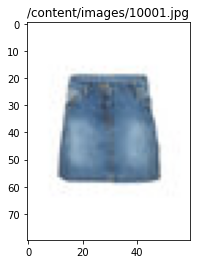

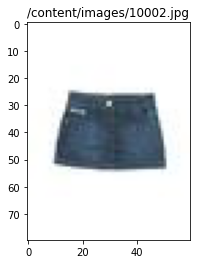

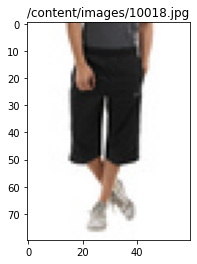

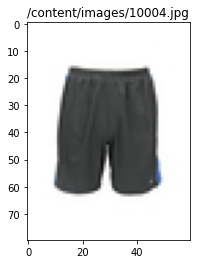

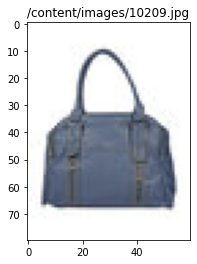

In [ ]:
for img_path in match_uris:
    img = Image.open(img_path)
    imshow(img)
    plt.title(img_path)
    plt.show()

## 3. Flow - the Design (Image + Text -> Product)

Search by multiple modalities beyond text box is much more common in these days. Multi-Modal search allows user to conduct their query with both image and text, and more.


But before it, let's think about two questions:

1. How to create a customized `Executor`.
2. How to create a jina `Document` which supports multiple modalities?

Let's first try to create a customized `Executor`:

In [ ]:
from jina import Executor, requests, DocumentArray

class DummyQueryIntentParser(Executor):
    
    @requests(on='/search')
    def parse_user_intent(self, docs: DocumentArray, **kwargs):
        for doc in docs:
            if 'adidas' in doc.content:
                doc.tags['intent'] = {'brand': 'adidas'}
            elif 'nike' in doc.content:
                doc.tags['intent'] = {'brand': 'nike'}
            else:
                doc.tags['intent'] = {'brand': 'unknown'}

In [ ]:
f = Flow().add(name='encoder').add(name='indexer').add(name='intent_parser', uses=DummyQueryIntentParser)
with f:
    resp = f.search(inputs=Document(content='black adidas sportshoes'), return_results=True)

for doc in resp[0].docs:
    print(doc.tags.dict())

        encoder@1957[D]:setting up sockets...
        encoder@1957[D]:control over tcp://0.0.0.0:51467
        encoder@1957[D]:input 0.0.0.0:50277
        encoder@1957[D]:input tcp://0.0.0.0:50277 (ROUTER_BIND) output tcp://0.0.0.0:56097 (ROUTER_BIND) control over tcp://0.0.0.0:51467 (PAIR_BIND)
        indexer@1958[D]:setting up sockets...
        indexer@1958[D]:control over tcp://0.0.0.0:43905
        encoder@1957[D]:recv ControlRequest (STATUS)  from ▸encoder/ZEDRuntime▸⚐
        indexer@1958[D]:input 0.0.0.0:52457
        encoder@1957[D]:skip executor: not data request
        encoder@60[D]:ready and listening
        indexer@1958[D]:input tcp://0.0.0.0:52457 (ROUTER_BIND) output tcp://0.0.0.0:60257 (ROUTER_BIND) control over tcp://0.0.0.0:43905 (PAIR_BIND)
⠋ 1/4 waiting indexer intent_parser gateway to be ready...        indexer@1958[D]:recv ControlRequest (STATUS)  from ▸indexer/ZEDRuntime▸⚐
        indexer@1958[D]:skip executor: not data request
        indexer@60[D]:ready and 

Together with Wordlift, we created a `UserIntentExecutor` which is able to map user query into 4 `facets`, including `Category`, `Color`, `Brand` and `Price`. This could leads to better search results use filtering.

In the backend, we could config `autointent=True` to apply this feature. For instance, if user query is `nike shoes sport black`, it will looks like this:

```python
from jina import Document

user_query = Document(content='nike shoes sport black')
flow = Flow()...

with flow:
    flow.search(inputs=user_query, parameters={'autointent': True})
```

our `UserIntentExecutor` will attach `tags` to the `user_query` as

```python
user_query = Document(
    content='nike shoes sport black',
    tags={'intent': {'color': 'black', 'brand': 'nike', 'category': 'shoe'}}
)
```

After matching documents by similar Vectors, we'll appply filter based on these recognized `tags`.



Now let's see how Jina represents a Multimodal Document contains 2 modalities (Image + Text): the answer is `Recursive Document Structure`. 

A `Document` can contains `Chunks` of `Documents`:

In [ ]:
d1 = Document(id=1)
d1.chunks.append(Document(id=2, uri='/content/images/10000.jpg'))
d1.chunks.append(Document(id=3, content='white skirt summer wear sports lady'))
d1

If wee look at the first chunk of the document `d1`, we can see some properties of the `Document` has been changed:

1. `granularity` has increased from 0 to 1.
2. `parent_id` of the `chunk` has been set to `1`, which is the id of the root `Document`.

In [ ]:
d1.chunks[0]

Now let's continue to design our Multimodal Index & Search Flow.

*NONTE, WE'RE NOT GOING TO IMPLEMENT IT THIS TIME, ONLY DEMONSTRATE THE DESIGN PRINCIPLE.*

Lets start from `Index Flow`:

In [ ]:
f_index = Flow().add(
    name='DocumentChunker').add(
    name='ImageModalityFilter').add(
    name='ImageObjectDetector').add(
    name='CLIPImageEncoder').add(
    name='AnnoyImageIndexer').add(
    name='TextModalityFilter', needs='DocumentChunker').add(
    name='BertTextEncoder').add(
    name='AnnoyTextIndexer').add(
    name='ChunkMerger', needs='DocumentChunker').add(
    name='JoinAll', needs=['AnnoyImageIndexer', 'AnnoyTextIndexer', 'ChunkMerger'])
f_index.plot()

           Flow@60[I]:flow visualization: https://mermaid.ink/svg/ICAgICAgICAgICAgJSV7aW5pdDp7ICAidGhlbWUiOiAiYmFzZSIsICAidGhlbWVWYXJpYWJsZXMiOiB7ICAgICAgInByaW1hcnlDb2xvciI6ICIjZmZmIiwgICAgICAicHJpbWFyeUJvcmRlckNvbG9yIjogIiNmZmYiLCAgICAgICJtYWluQmtnIjogIiMzMkM4Q0QiLCAgICAgICJjbHVzdGVyQmtnIjogIiNFRUVERTc4QyIsICAgICAgInNlY29uZGFyeUJvcmRlckNvbG9yIjogIm5vbmUiLCAgICAgICJ0ZXJ0aWFyeUJvcmRlckNvbG9yIjogIm5vbmUiLCAgICAgICJsaW5lQ29sb3IiOiAiI2E2ZDhkYSIgICAgICB9fX0lJSAgICAgICAgICAgIApmbG93Y2hhcnQgTFI7CnN1YmdyYXBoIERvY3VtZW50Q2h1bmtlcjsKRG9jdW1lbnRDaHVua2VyL3BlYS0wW0Jhc2VFeGVjdXRvcl06OjpQRUE7CmVuZDsKc3ViZ3JhcGggSW1hZ2VNb2RhbGl0eUZpbHRlcjsKSW1hZ2VNb2RhbGl0eUZpbHRlci9wZWEtMFtCYXNlRXhlY3V0b3JdOjo6UEVBOwplbmQ7CnN1YmdyYXBoIEltYWdlT2JqZWN0RGV0ZWN0b3I7CkltYWdlT2JqZWN0RGV0ZWN0b3IvcGVhLTBbQmFzZUV4ZWN1dG9yXTo6OlBFQTsKZW5kOwpzdWJncmFwaCBDTElQSW1hZ2VFbmNvZGVyOwpDTElQSW1hZ2VFbmNvZGVyL3BlYS0wW0Jhc2VFeGVjdXRvcl06OjpQRUE7CmVuZDsKc3ViZ3JhcGggQW5ub3lJbWFnZUluZGV4ZXI7CkFubm95SW1hZ2VJbmRleGVyL3BlYS0wW0Jhc2VFeGVjdXRvcl

Let's start the `Search Flow` design:

In [ ]:
f_search = Flow().add(
    name='DocumentChunker').add(
    name='ImageModalityFilter').add(
    name='ImageObjectDetector').add(
    name='CLIPImageEncoder').add(
    name='AnnoyImageIndexer').add(
    name='TextModalityFilter', needs='DocumentChunker').add(
    name='BertTextEncoder').add(
    name='AnnoyTextIndexer').add(
    name='ChunkMerger', needs=['AnnoyImageIndexer', 'AnnoyTextIndexer']).add(
    name='RankAggregator').add(
    name='IntentParser').add(
    name='ProductFilter')
f_search.plot()

           Flow@60[I]:flow visualization: https://mermaid.ink/svg/ICAgICAgICAgICAgJSV7aW5pdDp7ICAidGhlbWUiOiAiYmFzZSIsICAidGhlbWVWYXJpYWJsZXMiOiB7ICAgICAgInByaW1hcnlDb2xvciI6ICIjZmZmIiwgICAgICAicHJpbWFyeUJvcmRlckNvbG9yIjogIiNmZmYiLCAgICAgICJtYWluQmtnIjogIiMzMkM4Q0QiLCAgICAgICJjbHVzdGVyQmtnIjogIiNFRUVERTc4QyIsICAgICAgInNlY29uZGFyeUJvcmRlckNvbG9yIjogIm5vbmUiLCAgICAgICJ0ZXJ0aWFyeUJvcmRlckNvbG9yIjogIm5vbmUiLCAgICAgICJsaW5lQ29sb3IiOiAiI2E2ZDhkYSIgICAgICB9fX0lJSAgICAgICAgICAgIApmbG93Y2hhcnQgTFI7CnN1YmdyYXBoIERvY3VtZW50Q2h1bmtlcjsKRG9jdW1lbnRDaHVua2VyL3BlYS0wW0Jhc2VFeGVjdXRvcl06OjpQRUE7CmVuZDsKc3ViZ3JhcGggSW1hZ2VNb2RhbGl0eUZpbHRlcjsKSW1hZ2VNb2RhbGl0eUZpbHRlci9wZWEtMFtCYXNlRXhlY3V0b3JdOjo6UEVBOwplbmQ7CnN1YmdyYXBoIEltYWdlT2JqZWN0RGV0ZWN0b3I7CkltYWdlT2JqZWN0RGV0ZWN0b3IvcGVhLTBbQmFzZUV4ZWN1dG9yXTo6OlBFQTsKZW5kOwpzdWJncmFwaCBDTElQSW1hZ2VFbmNvZGVyOwpDTElQSW1hZ2VFbmNvZGVyL3BlYS0wW0Jhc2VFeGVjdXRvcl06OjpQRUE7CmVuZDsKc3ViZ3JhcGggQW5ub3lJbWFnZUluZGV4ZXI7CkFubm95SW1hZ2VJbmRleGVyL3BlYS0wW0Jhc2VFeGVjdXRvcl

## Scale-Up/Down

Jina is designed to help everyone build neural search solutions out-of-the-box, from Proof-of-Concept to Production.

Jina gives you a lot of possibilities to scale-up/down your application based on user's requirement.

In [ ]:
from jina import Flow

f = Flow().add(name='CLIPImageEncoder').add(name='AnnoyIndexer')
f.plot()

           Flow@60[I]:flow visualization: https://mermaid.ink/svg/ICAgICAgICAgICAgJSV7aW5pdDp7ICAidGhlbWUiOiAiYmFzZSIsICAidGhlbWVWYXJpYWJsZXMiOiB7ICAgICAgInByaW1hcnlDb2xvciI6ICIjZmZmIiwgICAgICAicHJpbWFyeUJvcmRlckNvbG9yIjogIiNmZmYiLCAgICAgICJtYWluQmtnIjogIiMzMkM4Q0QiLCAgICAgICJjbHVzdGVyQmtnIjogIiNFRUVERTc4QyIsICAgICAgInNlY29uZGFyeUJvcmRlckNvbG9yIjogIm5vbmUiLCAgICAgICJ0ZXJ0aWFyeUJvcmRlckNvbG9yIjogIm5vbmUiLCAgICAgICJsaW5lQ29sb3IiOiAiI2E2ZDhkYSIgICAgICB9fX0lJSAgICAgICAgICAgIApmbG93Y2hhcnQgTFI7CnN1YmdyYXBoIENMSVBJbWFnZUVuY29kZXI7CkNMSVBJbWFnZUVuY29kZXIvcGVhLTBbQmFzZUV4ZWN1dG9yXTo6OlBFQTsKZW5kOwpzdWJncmFwaCBBbm5veUluZGV4ZXI7CkFubm95SW5kZXhlci9wZWEtMFtCYXNlRXhlY3V0b3JdOjo6UEVBOwplbmQ7CmdhdGV3YXlzdGFydFtnYXRld2F5XTo6OkdBVEVXQVkgLS0+IENMSVBJbWFnZUVuY29kZXI6OjpQT0Q7CkNMSVBJbWFnZUVuY29kZXI6OjpQT0QgLS0+IEFubm95SW5kZXhlcjo6OlBPRDsKQW5ub3lJbmRleGVyOjo6UE9EIC0tPiBnYXRld2F5ZW5kW2dhdGV3YXldOjo6R0FURVdBWTsKY2xhc3NEZWYgSU5TUEVDVCBzdHJva2U6I0YyOUM5RgpjbGFzc0RlZiBKT0lOX0lOU1BFQ1Qgc3Ryb2tlOiNGMjlDOUYKY2xhc3

Some `Executors`, in this case, `CLIPIMageEncoder` might becomes the bottleneck. Because Deep neural networks takes time to inference, on `cpu`.

So the first option to resolve this bottleneck is to use GPU for inference.

In [ ]:
from jina import Flow

f = Flow().add(
    name='CLIPImageEncoderGPU', gpus='all', uses_with={'device': 'cuda'}).add(
    name='AnnoyIndexer'
)
f.plot()

           Flow@60[I]:flow visualization: https://mermaid.ink/svg/ICAgICAgICAgICAgJSV7aW5pdDp7ICAidGhlbWUiOiAiYmFzZSIsICAidGhlbWVWYXJpYWJsZXMiOiB7ICAgICAgInByaW1hcnlDb2xvciI6ICIjZmZmIiwgICAgICAicHJpbWFyeUJvcmRlckNvbG9yIjogIiNmZmYiLCAgICAgICJtYWluQmtnIjogIiMzMkM4Q0QiLCAgICAgICJjbHVzdGVyQmtnIjogIiNFRUVERTc4QyIsICAgICAgInNlY29uZGFyeUJvcmRlckNvbG9yIjogIm5vbmUiLCAgICAgICJ0ZXJ0aWFyeUJvcmRlckNvbG9yIjogIm5vbmUiLCAgICAgICJsaW5lQ29sb3IiOiAiI2E2ZDhkYSIgICAgICB9fX0lJSAgICAgICAgICAgIApmbG93Y2hhcnQgTFI7CnN1YmdyYXBoIENMSVBJbWFnZUVuY29kZXJHUFU7CkNMSVBJbWFnZUVuY29kZXJHUFUvcGVhLTBbQmFzZUV4ZWN1dG9yXTo6OlBFQTsKZW5kOwpzdWJncmFwaCBBbm5veUluZGV4ZXI7CkFubm95SW5kZXhlci9wZWEtMFtCYXNlRXhlY3V0b3JdOjo6UEVBOwplbmQ7CmdhdGV3YXlzdGFydFtnYXRld2F5XTo6OkdBVEVXQVkgLS0+IENMSVBJbWFnZUVuY29kZXJHUFU6OjpQT0Q7CkNMSVBJbWFnZUVuY29kZXJHUFU6OjpQT0QgLS0+IEFubm95SW5kZXhlcjo6OlBPRDsKQW5ub3lJbmRleGVyOjo6UE9EIC0tPiBnYXRld2F5ZW5kW2dhdGV3YXldOjo6R0FURVdBWTsKY2xhc3NEZWYgSU5TUEVDVCBzdHJva2U6I0YyOUM5RgpjbGFzc0RlZiBKT0lOX0lOU1BFQ1Qgc3Ryb2tlOi

In the meantime, Jina also supports `horizontal scaling`, simpliy put:

In [ ]:
from jina import Flow

f = Flow().add(
    name='CLIPImageEncoderGPU', gpus='all', uses_with={'device': 'cuda'}, replicas=3).add(
    name='AnnoyIndexer'
)
f.plot()

           Flow@60[I]:flow visualization: https://mermaid.ink/svg/ICAgICAgICAgICAgJSV7aW5pdDp7ICAidGhlbWUiOiAiYmFzZSIsICAidGhlbWVWYXJpYWJsZXMiOiB7ICAgICAgInByaW1hcnlDb2xvciI6ICIjZmZmIiwgICAgICAicHJpbWFyeUJvcmRlckNvbG9yIjogIiNmZmYiLCAgICAgICJtYWluQmtnIjogIiMzMkM4Q0QiLCAgICAgICJjbHVzdGVyQmtnIjogIiNFRUVERTc4QyIsICAgICAgInNlY29uZGFyeUJvcmRlckNvbG9yIjogIm5vbmUiLCAgICAgICJ0ZXJ0aWFyeUJvcmRlckNvbG9yIjogIm5vbmUiLCAgICAgICJsaW5lQ29sb3IiOiAiI2E2ZDhkYSIgICAgICB9fX0lJSAgICAgICAgICAgIApmbG93Y2hhcnQgTFI7CnN1YmdyYXBoIENMSVBJbWFnZUVuY29kZXJHUFU7CgpkaXJlY3Rpb24gTFI7CgpDTElQSW1hZ2VFbmNvZGVyR1BVL2hlYWRbQ0xJUEltYWdlRW5jb2RlckdQVS9oZWFkXTo6OkhFQURUQUlMIC0tPiBDTElQSW1hZ2VFbmNvZGVyR1BVL3JlcC0wW0Jhc2VFeGVjdXRvcl06OjpQRUE7CkNMSVBJbWFnZUVuY29kZXJHUFUvcmVwLTBbQmFzZUV4ZWN1dG9yXTo6OlBFQSAtLT4gQ0xJUEltYWdlRW5jb2RlckdQVS90YWlsW0NMSVBJbWFnZUVuY29kZXJHUFUvdGFpbF06OjpIRUFEVEFJTDsKQ0xJUEltYWdlRW5jb2RlckdQVS9oZWFkW0NMSVBJbWFnZUVuY29kZXJHUFUvaGVhZF06OjpIRUFEVEFJTCAtLT4gQ0xJUEltYWdlRW5jb2RlckdQVS9yZXAtMVtCYXNlRXhlY3V0b3JdOj

The above `CLIPImageEncoder` has been scaled 3 times, but this `Executor` is a `Stateless Executor`, it does not keep any states/data inside.

When it comes to a `Stateful Executor`, such as a `Indexer` to store the indexed data. For instance, we use `MongoDB` to persist our `Documents` for `incremental indexing`:

In [ ]:
from jina import Flow

f_search = Flow().add(
    name='CLIPImageEncoderGPU', gpus='all', uses_with={'device': 'cuda'}).add(
    name='MongoDBStorage', shards=3).add(
    name='AnnoyIndexer'
)
f_search.plot()

           Flow@60[I]:flow visualization: https://mermaid.ink/svg/ICAgICAgICAgICAgJSV7aW5pdDp7ICAidGhlbWUiOiAiYmFzZSIsICAidGhlbWVWYXJpYWJsZXMiOiB7ICAgICAgInByaW1hcnlDb2xvciI6ICIjZmZmIiwgICAgICAicHJpbWFyeUJvcmRlckNvbG9yIjogIiNmZmYiLCAgICAgICJtYWluQmtnIjogIiMzMkM4Q0QiLCAgICAgICJjbHVzdGVyQmtnIjogIiNFRUVERTc4QyIsICAgICAgInNlY29uZGFyeUJvcmRlckNvbG9yIjogIm5vbmUiLCAgICAgICJ0ZXJ0aWFyeUJvcmRlckNvbG9yIjogIm5vbmUiLCAgICAgICJsaW5lQ29sb3IiOiAiI2E2ZDhkYSIgICAgICB9fX0lJSAgICAgICAgICAgIApmbG93Y2hhcnQgTFI7CnN1YmdyYXBoIENMSVBJbWFnZUVuY29kZXJHUFU7CkNMSVBJbWFnZUVuY29kZXJHUFUvcGVhLTBbQmFzZUV4ZWN1dG9yXTo6OlBFQTsKZW5kOwpzdWJncmFwaCBNb25nb0RCU3RvcmFnZTsKCmRpcmVjdGlvbiBMUjsKCnN1YmdyYXBoIE1vbmdvREJTdG9yYWdlL3NoYXJkLTAKCk1vbmdvREJTdG9yYWdlL3NoYXJkLTAvcGVhLTBbQmFzZUV4ZWN1dG9yXTo6OlBFQQoKZW5kCgoKCnN1YmdyYXBoIE1vbmdvREJTdG9yYWdlL3NoYXJkLTEKCk1vbmdvREJTdG9yYWdlL3NoYXJkLTEvcGVhLTBbQmFzZUV4ZWN1dG9yXTo6OlBFQQoKZW5kCgoKCnN1YmdyYXBoIE1vbmdvREJTdG9yYWdlL3NoYXJkLTIKCk1vbmdvREJTdG9yYWdlL3NoYXJkLTIvcGVhLTBbQmFzZUV4ZWN1dG9yXT

But..for small customers.. budget might becomes an issue.

An example is, when use `GPU` as `Executor`, the cost might be expensive. For instance, a `GPU` machine hosted on AWS normally cost 1-15 dollars per hour. Is there a chance for small shop owners make use of Jina while still keep their budget?

In [ ]:
from jina import Flow

f_customer_1 = Flow().add(
    name='CLIPImageEncoderGPU', gpus='all', uses_with={'device': 'cuda'}).add(
    name='MongoDBStorage', shards=3).add(
    name='AnnoyIndexer'
)

f_customer_2 = Flow().add(
    name='CLIPImageEncoderGPU', gpus='all', uses_with={'device': 'cuda'}).add(
    name='MongoDBStorage', shards=3).add(
    name='AnnoyIndexer'
)

We could allow different customer to `Share an Executor`:

In [ ]:
from jina import Flow

f_customer_1 = Flow().add(
    name='RemoteCLIPImageEncoderGPU', gpus='all', uses_with={'device': 'cuda'}, host='11.11.11.11', external=True).add(
    name='MongoDBStorage', shards=3).add(
    name='AnnoyIndexer'
)

f_customer_2 = Flow().add(
    name='RemoteCLIPImageEncoderGPU', gpus='all', uses_with={'device': 'cuda'}, host='11.11.11.11', external=True).add(
    name='MongoDBStorage', shards=3).add(
    name='AnnoyIndexer'
)
    
f_customer_1.plot()

           Flow@60[I]:flow visualization: https://mermaid.ink/svg/ICAgICAgICAgICAgJSV7aW5pdDp7ICAidGhlbWUiOiAiYmFzZSIsICAidGhlbWVWYXJpYWJsZXMiOiB7ICAgICAgInByaW1hcnlDb2xvciI6ICIjZmZmIiwgICAgICAicHJpbWFyeUJvcmRlckNvbG9yIjogIiNmZmYiLCAgICAgICJtYWluQmtnIjogIiMzMkM4Q0QiLCAgICAgICJjbHVzdGVyQmtnIjogIiNFRUVERTc4QyIsICAgICAgInNlY29uZGFyeUJvcmRlckNvbG9yIjogIm5vbmUiLCAgICAgICJ0ZXJ0aWFyeUJvcmRlckNvbG9yIjogIm5vbmUiLCAgICAgICJsaW5lQ29sb3IiOiAiI2E2ZDhkYSIgICAgICB9fX0lJSAgICAgICAgICAgIApmbG93Y2hhcnQgTFI7CnN1YmdyYXBoIE1vbmdvREJTdG9yYWdlOwoKZGlyZWN0aW9uIExSOwoKc3ViZ3JhcGggTW9uZ29EQlN0b3JhZ2Uvc2hhcmQtMAoKTW9uZ29EQlN0b3JhZ2Uvc2hhcmQtMC9wZWEtMFtCYXNlRXhlY3V0b3JdOjo6UEVBCgplbmQKCgoKc3ViZ3JhcGggTW9uZ29EQlN0b3JhZ2Uvc2hhcmQtMQoKTW9uZ29EQlN0b3JhZ2Uvc2hhcmQtMS9wZWEtMFtCYXNlRXhlY3V0b3JdOjo6UEVBCgplbmQKCgoKc3ViZ3JhcGggTW9uZ29EQlN0b3JhZ2Uvc2hhcmQtMgoKTW9uZ29EQlN0b3JhZ2Uvc2hhcmQtMi9wZWEtMFtCYXNlRXhlY3V0b3JdOjo6UEVBCgplbmQKCgoKTW9uZ29EQlN0b3JhZ2UvaGVhZDo6OkhFQURUQUlMIC0tPiBNb25nb0RCU3RvcmFnZS9zaGFyZC0wOwpNb25nb0RCU3

In [ ]:
f_customer_2.plot()

           Flow@60[I]:flow visualization: https://mermaid.ink/svg/ICAgICAgICAgICAgJSV7aW5pdDp7ICAidGhlbWUiOiAiYmFzZSIsICAidGhlbWVWYXJpYWJsZXMiOiB7ICAgICAgInByaW1hcnlDb2xvciI6ICIjZmZmIiwgICAgICAicHJpbWFyeUJvcmRlckNvbG9yIjogIiNmZmYiLCAgICAgICJtYWluQmtnIjogIiMzMkM4Q0QiLCAgICAgICJjbHVzdGVyQmtnIjogIiNFRUVERTc4QyIsICAgICAgInNlY29uZGFyeUJvcmRlckNvbG9yIjogIm5vbmUiLCAgICAgICJ0ZXJ0aWFyeUJvcmRlckNvbG9yIjogIm5vbmUiLCAgICAgICJsaW5lQ29sb3IiOiAiI2E2ZDhkYSIgICAgICB9fX0lJSAgICAgICAgICAgIApmbG93Y2hhcnQgTFI7CnN1YmdyYXBoIE1vbmdvREJTdG9yYWdlOwoKZGlyZWN0aW9uIExSOwoKc3ViZ3JhcGggTW9uZ29EQlN0b3JhZ2Uvc2hhcmQtMAoKTW9uZ29EQlN0b3JhZ2Uvc2hhcmQtMC9wZWEtMFtCYXNlRXhlY3V0b3JdOjo6UEVBCgplbmQKCgoKc3ViZ3JhcGggTW9uZ29EQlN0b3JhZ2Uvc2hhcmQtMQoKTW9uZ29EQlN0b3JhZ2Uvc2hhcmQtMS9wZWEtMFtCYXNlRXhlY3V0b3JdOjo6UEVBCgplbmQKCgoKc3ViZ3JhcGggTW9uZ29EQlN0b3JhZ2Uvc2hhcmQtMgoKTW9uZ29EQlN0b3JhZ2Uvc2hhcmQtMi9wZWEtMFtCYXNlRXhlY3V0b3JdOjo6UEVBCgplbmQKCgoKTW9uZ29EQlN0b3JhZ2UvaGVhZDo6OkhFQURUQUlMIC0tPiBNb25nb0RCU3RvcmFnZS9zaGFyZC0wOwpNb25nb0RCU3

## 5. The missing block: on-the-shelf pre-trained model to your task

Usually, on-the-shelf pre-trained deep learning models are useful to create something fast for Proof-of-Concept, but not enough yet for serving end customers.

Why? Because most of the pre-trained models are optimized for certain domain. For example `VGGNet`, `ResNet`, `VisionTransformers` are mostly pre-trained on `ImageNet` dataset, contains concepts suc as "balloon" or "strawberry". This model ouput embeddings on the dataset might not sutble for your task. In this case, it's `Fashion Search`.

We adopted the idea of `Transfer Learning` and `Metric Learning`, and developed a new open-source toolket called `finetuner`.

> In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest

> Deep Neural Network with a similar ability to tell which objects are visually/semantically similar and which ones are not

![metric learning](https://hav4ik.github.io/articles/images/2021-06-14-deep-metric-learning-survey/triplet_loss.png)

In [ ]:
import finetuner as ft
import torchvision.models as models

vgg16 = models.vgg16(pretrained=True)

In [ ]:
ft.display(vgg16, input_size=(3, 224, 224))

 name                   output_shape_display   nb_params   trainable  
 ───────────────────────────────────────────────────────────────────── 
  conv2d_1               [64, 224, 224]         1792        True       
  relu_2                 [64, 224, 224]         0           False      
  conv2d_3               [64, 224, 224]         36928       True       
  relu_4                 [64, 224, 224]         0           False      
  maxpool2d_5            [64, 112, 112]         0           False      
  conv2d_6               [128, 112, 112]        73856       True       
  relu_7                 [128, 112, 112]        0           False      
  conv2d_8               [128, 112, 112]        147584      True       
  relu_9                 [128, 112, 112]        0           False      
  maxpool2d_10           [128, 56, 56]          0           False      
  conv2d_11              [256, 56, 56]          295168      True       
  relu_12                [256, 56, 56]          0           False      
  conv2d_13              [256, 56, 56]          590080      True       
  relu_14                [256, 56, 56]          0           False      
  conv2d_15              [256, 56, 56]          590080      True       
  relu_16                [256, 56, 56]          0           False      
  maxpool2d_17           [256, 28, 28]          0           False      
  conv2d_18              [512, 28, 28]          1180160     True       
  relu_19                [512, 28, 28]          0           False      
  conv2d_20              [512, 28, 28]          2359808     True       
  relu_21                [512, 28, 28]          0           False      
  conv2d_22              [512, 28, 28]          2359808     True       
  relu_23                [512, 28, 28]          0           False      
  maxpool2d_24           [512, 14, 14]          0           False      
  conv2d_25              [512, 14, 14]          2359808     True       
  relu_26                [512, 14, 14]          0           False      
  conv2d_27              [512, 14, 14]          2359808     True       
  relu_28                [512, 14, 14]          0           False      
  conv2d_29              [512, 14, 14]          2359808     True       
  relu_30                [512, 14, 14]          0           False      
  maxpool2d_31           [512, 7, 7]            0           False      
  adaptiveavgpool2d_32   [512, 7, 7]            0           False      
  linear_33              [4096]                 102764544   True       
  relu_34                [4096]                 0           False      
  dropout_35             [4096]                 0           False      
  linear_36              [4096]                 16781312    True       
  relu_37                [4096]                 0           False      
  dropout_38             [4096]                 0           False      
  linear_39              [1000]                 4097000     True       
                                                                       
Green layers can be used as embedding layers, whose name can be used as layer_name in 
to_embedding_model(...).

```python
import random

import numpy as np
import finetuner as ft
from jina import Document, DocumentArray

da = DocumentArray()
for i in range(100):
    doc = Document(content=np.random.rand(3, 224, 224).astype(np.float32), tags={'finetuner_label': random.randint(0,9)})
    da.append(doc)

finetuned_model = ft.fit(
    model=vgg16,
    train_data=da,
    epochs=2,
    batch_size=16,
    learning_rate=1e-3,
    device='cpu', # or cuda
    loss='SiameseLoss',
    to_embedding_model=True,
    layer_name='linear_33',
    input_size=(3, 224, 224),
)
```

## 6. Flow-As-A-Service & Deploy 

In [ ]:
from jina import Flow 

f = Flow(protocol='grpc', port_expose=123456).add().add() ## grpc, websocket, http
with f:
    f.block()

      executor0@2387[D]:setting up sockets...
⠋ 0/3 waiting executor0 executor1 gateway to be ready...      executor0@2387[D]:control over tcp://0.0.0.0:55961
      executor0@2387[D]:input 0.0.0.0:47315
      executor0@2387[D]:input tcp://0.0.0.0:47315 (ROUTER_BIND) output tcp://0.0.0.0:33219 (ROUTER_BIND) control over tcp://0.0.0.0:55961 (PAIR_BIND)
        gateway@2389[D]:setting up sockets...
      executor1@2388[D]:setting up sockets...
      executor1@2388[D]:control over tcp://0.0.0.0:60135
        gateway@2389[D]:control over ipc:///tmp/tmpt37ilwuz
      executor1@2388[D]:input 0.0.0.0:51737
      executor1@2388[D]:input tcp://0.0.0.0:51737 (ROUTER_BIND) output tcp://0.0.0.0:49513 (ROUTER_BIND) control over tcp://0.0.0.0:60135 (PAIR_BIND)
        gateway@2389[D]:input 0.0.0.0:35479
        gateway@2389[D]:input tcp://0.0.0.0:35479 (ROUTER_BIND) output tcp://0.0.0.0:50923 (ROUTER_BIND) control over ipc:///tmp/tmpt37ilwuz (PAIR_BIND)
⠙ 0/3 waiting executor0 executor1 gateway to be

In [ ]:
f = Flow(infrastructure='k8s').add(name='k8s_executor1', replicas=2).add(name='k8s_executor2', replicas=3)
f.plot()

           Flow@60[I]:flow visualization: https://mermaid.ink/svg/ICAgICAgICAgICAgJSV7aW5pdDp7ICAidGhlbWUiOiAiYmFzZSIsICAidGhlbWVWYXJpYWJsZXMiOiB7ICAgICAgInByaW1hcnlDb2xvciI6ICIjZmZmIiwgICAgICAicHJpbWFyeUJvcmRlckNvbG9yIjogIiNmZmYiLCAgICAgICJtYWluQmtnIjogIiMzMkM4Q0QiLCAgICAgICJjbHVzdGVyQmtnIjogIiNFRUVERTc4QyIsICAgICAgInNlY29uZGFyeUJvcmRlckNvbG9yIjogIm5vbmUiLCAgICAgICJ0ZXJ0aWFyeUJvcmRlckNvbG9yIjogIm5vbmUiLCAgICAgICJsaW5lQ29sb3IiOiAiI2E2ZDhkYSIgICAgICB9fX0lJSAgICAgICAgICAgIApmbG93Y2hhcnQgTFI7CnN1YmdyYXBoIGs4c19leGVjdXRvcjE7CgpkaXJlY3Rpb24gTFI7CgprOHNfZXhlY3V0b3IxL3JlcGxpY2EtMFtCYXNlRXhlY3V0b3JdOwprOHNfZXhlY3V0b3IxL3JlcGxpY2EtMVtCYXNlRXhlY3V0b3JdOwplbmQ7CnN1YmdyYXBoIGs4c19leGVjdXRvcjI7CgpkaXJlY3Rpb24gTFI7CgprOHNfZXhlY3V0b3IyL3JlcGxpY2EtMFtCYXNlRXhlY3V0b3JdOwprOHNfZXhlY3V0b3IyL3JlcGxpY2EtMVtCYXNlRXhlY3V0b3JdOwprOHNfZXhlY3V0b3IyL3JlcGxpY2EtMltCYXNlRXhlY3V0b3JdOwplbmQ7CmdhdGV3YXlzdGFydFtnYXRld2F5XTo6OkdBVEVXQVkgLS0+IGs4c19leGVjdXRvcjE6OjpQT0Q7Cms4c19leGVjdXRvcjE6OjpQT0QgLS0+IGs4c19leGVjdXRvcj

More on the deployment, please check [this](https://github.com/jina-ai/jina#deploy-to-kubernetes-in-7-minutes-) link, and we complete our pipeline

![pipeline](https://github.com/jina-ai/jina/raw/master/.github/images/readme-get-started.svg?raw=true)